<a href="https://colab.research.google.com/github/dgo95/TFG_IDENTIFICACION_AVES/blob/main/ResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==2.8
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 3 not upgraded.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.applications.efficientnet import preprocess_input
import matplotlib.pyplot as plt #Dibujo
import numpy as np
from sklearn.utils import class_weight
import os
from sklearn.model_selection import train_test_split
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf
import tensorflow.keras.activations as nn
import time as tempo
import pandas as pd
# Import seaborn
import seaborn as sns

In [ ]:
"""ResNet-18
Reference:
[1] K. He et al. Deep Residual Learning for Image Recognition. CVPR, 2016
[2] K. He, X. Zhang, S. Ren, and J. Sun. Delving deep into rectifiers:
Surpassing human-level performance on imagenet classification. In
ICCV, 2015.
"""


from keras.callbacks import EarlyStopping
from keras.layers import Dense, Conv2D,  MaxPool2D, Flatten, GlobalAveragePooling2D,  BatchNormalization, Layer, Add
from keras.models import Sequential
from keras.models import Model
import tensorflow as tf


class ResnetBlock(Model):
    """
    A standard resnet block.
    """

    def __init__(self, channels: int, down_sample=False):
        """
        channels: same as number of convolution kernels
        """
        super().__init__()

        self.__channels = channels
        self.__down_sample = down_sample
        self.__strides = [2, 1] if down_sample else [1, 1]

        KERNEL_SIZE = (3, 3)
        # use He initialization, instead of Xavier (a.k.a 'glorot_uniform' in Keras), as suggested in [2]
        INIT_SCHEME = "he_normal"
        

        self.conv_1 = Conv2D(self.__channels, strides=self.__strides[0],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=0.02))
        self.bn_1 = BatchNormalization()
        self.conv_2 = Conv2D(self.__channels, strides=self.__strides[1],
                             kernel_size=KERNEL_SIZE, padding="same", kernel_initializer=tf.keras.initializers.RandomNormal(mean=1., stddev=0.02))
        self.bn_2 = BatchNormalization()
        self.merge = Add()

        if self.__down_sample:
            # perform down sampling using stride of 2, according to [1].
            self.res_conv = Conv2D(
                self.__channels, strides=2, kernel_size=(1, 1), kernel_initializer=INIT_SCHEME, padding="same")
            self.res_bn = BatchNormalization()

    def call(self, inputs):
        res = inputs

        x = self.conv_1(inputs)
        x = self.bn_1(x)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        x = self.bn_2(x)

        if self.__down_sample:
            res = self.res_conv(res)
            res = self.res_bn(res)

        # if not perform down sample, then add a shortcut directly
        x = self.merge([x, res])
        out = tf.nn.relu(x)
        return out


class ResNet18(Model):

    def __init__(self, num_classes, **kwargs):
        """
            num_classes: number of classes in specific classification task.
        """
        super().__init__(**kwargs)
        self.conv_1 = Conv2D(64, (7, 7), strides=2,
                             padding="same", kernel_initializer="he_normal")
        self.init_bn = BatchNormalization()
        self.pool_2 = MaxPool2D(pool_size=(2, 2), strides=2, padding="same")
        self.res_1_1 = ResnetBlock(64)
        self.res_1_2 = ResnetBlock(64)
        self.res_2_1 = ResnetBlock(128, down_sample=True)
        self.res_2_2 = ResnetBlock(128)
        self.res_3_1 = ResnetBlock(256, down_sample=True)
        self.res_3_2 = ResnetBlock(256)
        self.res_4_1 = ResnetBlock(512, down_sample=True)
        self.res_4_2 = ResnetBlock(512)
        self.avg_pool = GlobalAveragePooling2D()
        self.flat = Flatten()
        self.fc = Dense(num_classes, activation="softmax")

    def call(self, inputs):
        out = self.conv_1(inputs)
        out = self.init_bn(out)
        out = tf.nn.relu(out)
        out = self.pool_2(out)
        for res_block in [self.res_1_1, self.res_1_2, self.res_2_1, self.res_2_2, self.res_3_1, self.res_3_2, self.res_4_1, self.res_4_2]:
            out = res_block(out)
        out = self.avg_pool(out)
        out = self.flat(out)
        out = self.fc(out)
        return out

In [ ]:
def enHorasYMinutos(seg):
    horas = seg // 3600
    seg = seg - horas * 3600
    minutos = seg // 60
    seg = seg - minutos *60
    aux = str(int(horas))+" horas "+str(int(minutos))+" minutos y "+str(int(seg))+" segundos"
    return aux

In [ ]:
EPOCAS = 100
lr = 0.1
BATCH_SIZE = 64
#cargar datos
train_images = []
train_labels = []
test_images = []
test_labels = []
val_images = []
val_labels = []
# lectura de los datos

path = os.path.join('drive',"MyDrive","Colab Notebooks", "Cuaderno1")
entrenamientoPath=os.path.join(path,"DataSet","Espectrogramas", "train")
testPath = os.path.join(path,"DataSet","Espectrogramas", "test")
valPath = os.path.join(path,"DataSet","Espectrogramas", "val")
etiqueta = -1
NUM_AVES=-1
IM_SIZE1 = (216, 192)
leyenda = {}
BIRDS = []

In [ ]:
for nombre_directorio, dirs, ficheros in os.walk(entrenamientoPath):
    NUM_AVES = NUM_AVES + 1
    for nombre_fichero in ficheros:
        ruta=os.path.join(nombre_directorio,nombre_fichero)
        filename, file_extension = os.path.splitext(ruta)
        # cargar la interfaz a la base de datos que vienen con keras
        # lectura de los datos
        image = tf.keras.preprocessing.image.load_img(ruta,color_mode="grayscale")
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        #input_arr = np.dot(input_arr[...,:3], rgb_weights).round()
        #input_arr = np.array([input_arr])  # Convert single image to a batch.
        train_images.append(input_arr)
        train_labels.append(etiqueta)
    etiqueta = etiqueta + 1
etiqueta = -1
for nombre_directorio, dirs, ficheros in os.walk(testPath):
    print("Directorio: ",nombre_directorio)
    print("Etiqueta: ",etiqueta)
    for nombre_fichero in ficheros:
        ruta=os.path.join(nombre_directorio,nombre_fichero)
        filename, file_extension = os.path.splitext(ruta)
        # cargar la interfaz a la base de datos que vienen con keras
        # lectura de los datos
        image = tf.keras.preprocessing.image.load_img(ruta,color_mode="grayscale")
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        #input_arr = np.dot(input_arr[...,:3], rgb_weights).round()
        #input_arr = np.array([input_arr])  # Convert single image to a batch.
        test_images.append(input_arr)
        test_labels.append(etiqueta)
    etiqueta = etiqueta + 1
etiqueta = -1
for nombre_directorio, dirs, ficheros in os.walk(valPath):
    print("Directorio: ",nombre_directorio)
    print("Etiqueta: ",etiqueta)
    for nombre_fichero in ficheros:
        ruta=os.path.join(nombre_directorio,nombre_fichero)
        filename, file_extension = os.path.splitext(ruta)
        # cargar la interfaz a la base de datos que vienen con keras
        # lectura de los datos
        image = tf.keras.preprocessing.image.load_img(ruta,color_mode="grayscale")
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        #input_arr = np.dot(input_arr[...,:3], rgb_weights).round()
        #input_arr = np.array([input_arr])  # Convert single image to a batch.
        val_images.append(input_arr)
        val_labels.append(etiqueta)
    etiqueta = etiqueta + 1

Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/test
Etiqueta:  -1
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/test/Emberiza cirlus_Cirl Bunting
Etiqueta:  0
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/test/Serinus serinus_European Serin
Etiqueta:  1
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/test/Emberiza citrinella_Yellowhammer
Etiqueta:  2
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/val
Etiqueta:  -1
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/val/Emberiza cirlus_Cirl Bunting
Etiqueta:  0
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/val/Serinus serinus_European Serin
Etiqueta:  1
Directorio:  drive/MyDrive/Colab Notebooks/Cuaderno1/DataSet/Espectrogramas/val/Emberiza citrinella_Yellowhammer
Etiqueta:  2


In [ ]:
x = []
y = []
z = []
print("Entrenamiento")
for t in train_images:
  x.append(t.shape[0])
  y.append(t.shape[1])
  z.append(t.shape[2])
print("Maximos x: ",np.max(x)," y: ",np.max(y)," z: ",np.max(z))
print("Minimos x: ",np.min(x)," y: ",np.min(y)," z: ",np.min(z))
x = []
y = []
z = []
print("Test")
for t in test_images:
  x.append(t.shape[0])
  y.append(t.shape[1])
  z.append(t.shape[2])
print("Maximos x: ",np.max(x)," y: ",np.max(y)," z: ",np.max(z))
print("Minimos x: ",np.min(x)," y: ",np.min(y)," z: ",np.min(z))
x = []
y = []
z = []
print("Validación")
for t in val_images:
  x.append(t.shape[0])
  y.append(t.shape[1])
  z.append(t.shape[2])
print("Maximos x: ",np.max(x)," y: ",np.max(y)," z: ",np.max(z))
print("Minimos x: ",np.min(x)," y: ",np.min(y)," z: ",np.min(z))

Entrenamiento
Maximos x:  192  y:  265  z:  1
Minimos x:  192  y:  265  z:  1
Test
Maximos x:  192  y:  265  z:  1
Minimos x:  192  y:  265  z:  1
Validación
Maximos x:  192  y:  265  z:  1
Minimos x:  192  y:  265  z:  1


In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
print('Dimensiones del conjunto de entrenamiento: ', train_images.shape)
print('Dimensiones del conjunto de evaluación: ',    test_images.shape)
print('Dimensiones del conjunto de validación: ',    val_images.shape)

print('Dimensiones del conjunto de entrenamiento: ', train_labels.shape)
print('Dimensiones del conjunto de evaluación: ',    test_labels.shape)
print('Dimensiones del conjunto de validación: ',    val_labels.shape)

Dimensiones del conjunto de entrenamiento:  (722, 192, 265, 1)
Dimensiones del conjunto de evaluación:  (87, 192, 265, 1)
Dimensiones del conjunto de validación:  (90, 192, 265, 1)
Dimensiones del conjunto de entrenamiento:  (722,)
Dimensiones del conjunto de evaluación:  (87,)
Dimensiones del conjunto de validación:  (90,)


In [ ]:
b = train_images.shape[0]
c = test_images.shape[0]
d = val_images.shape[0]

#train_images = train_images.reshape((b, -1))
train_images = train_images.astype('float32') / 255

#test_images  = test_images.reshape((c, -1))
test_images  = test_images.astype('float32') / 255

#val_images  = val_images.reshape((c, -1))
val_images  = val_images.astype('float32') / 255

#numIm, szIm  = train_images.shape

# One shot sobre las etiquetas

train_labels = to_categorical(train_labels)
test_labels  = to_categorical(test_labels)
val_labels  = to_categorical(val_labels)

In [ ]:
a = train_images.shape[1:]
a = list(a)
a.insert(0,None)
s = tuple(a)
model = ResNet18(NUM_AVES)
model.build(input_shape = s)
#use categorical_crossentropy since the label is one-hot encoded
sgd = tf.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.9)
model.compile(optimizer = sgd,loss='categorical_crossentropy', metrics=["accuracy"]) 
model.summary()

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "res_net18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  3200      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 resnet_block (ResnetBlock)  multiple                  74368     
                                                                 
 resnet_block_1 (ResnetBlock  multiple              

In [ ]:
tic=tempo.time()

history = model.fit(x         = train_images, 
                    y         = train_labels, 
                    epochs    = EPOCAS, 
                    shuffle   = True,
                    batch_size= 64,
                    validation_data=  (val_images, val_labels),
                    verbose   = 2)

print('Tiempo de procesamiento (secs): ', enHorasYMinutos(tempo.time()-tic))

Epoch 1/100
12/12 - 11s - loss: 8.0850 - accuracy: 0.3560 - val_loss: 8879496192.0000 - val_accuracy: 0.3333 - 11s/epoch - 931ms/step
Epoch 2/100
12/12 - 2s - loss: 8.8974 - accuracy: 0.3449 - val_loss: 6701999.0000 - val_accuracy: 0.3333 - 2s/epoch - 192ms/step
Epoch 3/100
12/12 - 2s - loss: 7.5378 - accuracy: 0.3629 - val_loss: 1105220.8750 - val_accuracy: 0.3333 - 2s/epoch - 191ms/step
Epoch 4/100
12/12 - 2s - loss: 7.3298 - accuracy: 0.3130 - val_loss: 5426716.5000 - val_accuracy: 0.3333 - 2s/epoch - 191ms/step
Epoch 5/100
12/12 - 2s - loss: 8.5490 - accuracy: 0.3075 - val_loss: 783486.7500 - val_accuracy: 0.3333 - 2s/epoch - 191ms/step
Epoch 6/100
12/12 - 2s - loss: 3.1713 - accuracy: 0.3601 - val_loss: 23407.7148 - val_accuracy: 0.3333 - 2s/epoch - 191ms/step
Epoch 7/100
12/12 - 2s - loss: 1.2015 - accuracy: 0.3532 - val_loss: 3982.9795 - val_accuracy: 0.3333 - 2s/epoch - 191ms/step
Epoch 8/100
12/12 - 2s - loss: 1.1004 - accuracy: 0.4363 - val_loss: 1198.2257 - val_accuracy: 0.3

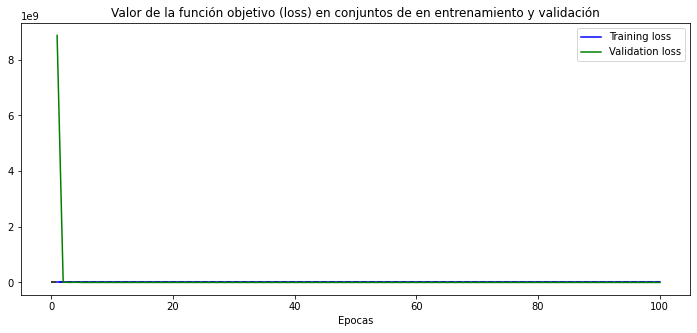

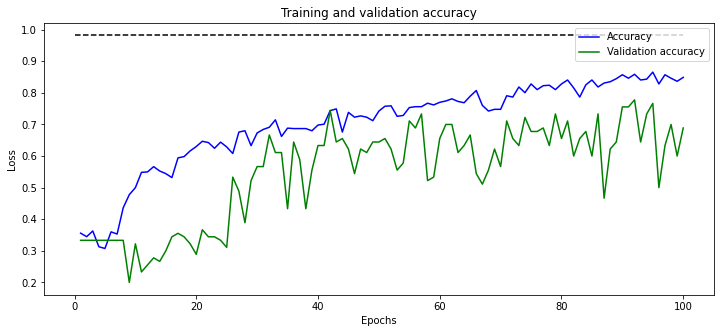

3/3 [==============================] - 1s 198ms/step - loss: 0.6477 - accuracy: 0.6782
[0.6476829051971436, 0.6781609058380127]


In [ ]:
history_dict = history.history
dictkeys=list(history_dict.keys())
# Mostrar resultados.

loss_values     = history.history['loss']
val_loss_values = history.history['val_loss']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(12,5))
plt.plot(epochs, loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'g', label='Validation loss')
plt.title('Valor de la función objetivo (loss) en conjuntos de en entrenamiento y validación')
plt.xlabel('Epocas')
plt.ylabel('')
plt.hlines(y=.078, xmin=0, xmax=EPOCAS, colors='k', linestyles='dashed')
plt.legend()

plt.show()


acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.figure(figsize=(12,5))
plt.plot(epochs, acc_values, 'b', label='Accuracy')
plt.plot(epochs, val_acc_values, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.hlines(y=.982, xmin=0, xmax=EPOCAS, colors='k', linestyles='dashed')
plt.legend()

plt.show()

results = model.evaluate(test_images, test_labels)
print(results)

In [ ]:
classes= [0,1,2]

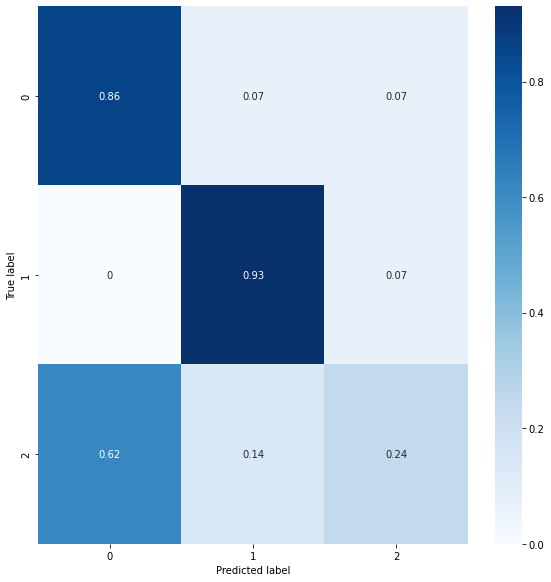

{}


In [ ]:
y_pred=model.predict(test_images)

con_mat = tf.math.confusion_matrix(labels=np.argmax(test_labels,axis=1), predictions=np.argmax(y_pred,axis=1)).numpy()

con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)

con_mat_df = pd.DataFrame(con_mat_norm,
                     index = classes, 
                     columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
print(leyenda)